In [2]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [3]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('E:/Speech_Emotion_Recognition/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
import pandas as pd
# Create DataFrame for Data intel

data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('E:/Speech_Emotion_Recognition/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'E:/Speech_Emotion_Recognition/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1


In [5]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,1
1,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,1,1
2,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,0,1
3,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,1,1
4,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,2


In [6]:
# Reading and loading the file from given path
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

E:/Speech_Emotion_Recognition/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [7]:
len(samples), sample_rate

(77989, 22050)

In [8]:
#Compute a spectrogram with consecutive Fourier transforms.
#Spectrograms can be used as a way of visualizing the change of a nonstationary signal’s frequency content over time.

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [9]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5, 0, 'Seconds')

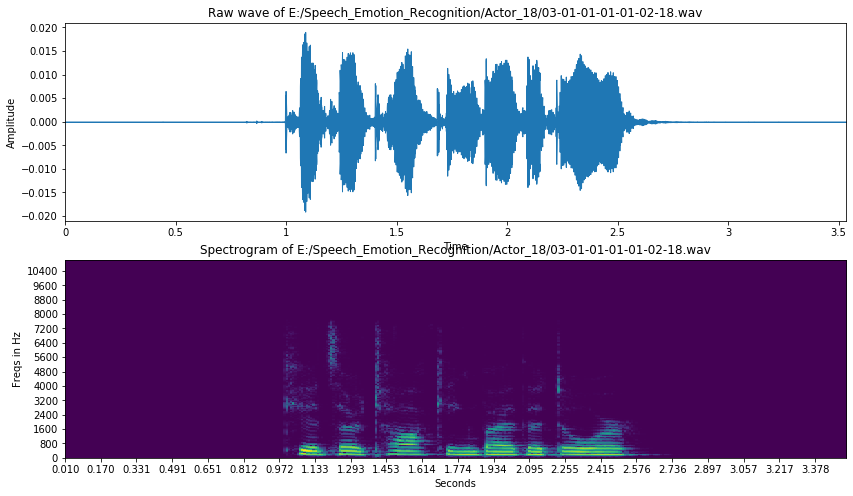

In [10]:
# Plotting Wave Form and Spectrogram
import IPython.display as ipd
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [11]:
# Finding out the unique features in the spectogram

mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [12]:
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-4.1766889e-06,  8.8026241e-07,  1.7132825e-06, ...,
         3.9874478e-05,  1.8862544e-05,  9.0871117e-07], dtype=float32),
 array([20992, 58880]))

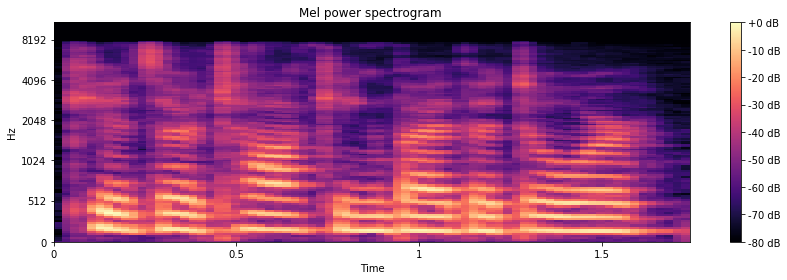

In [13]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

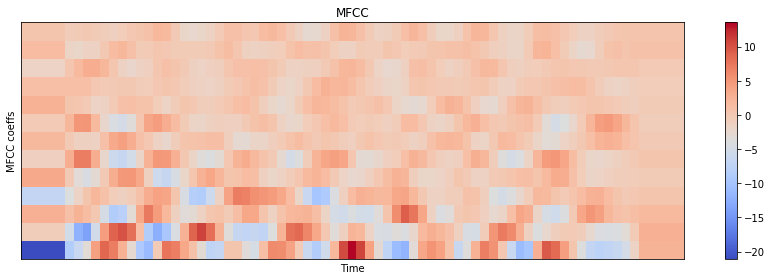

In [14]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [15]:
ipd.Audio(samples, rate=sample_rate)

In [16]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [17]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [18]:
label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [19]:
# Selecting the label
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,1,male_neutral
1,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,1,1,male_neutral
2,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,0,1,male_neutral
3,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,1,1,male_neutral
4,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,2,male_calm


In [20]:
print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'female_calm', 'female_happy', 'male_angry',
       'female_angry', 'male_sad', 'female_fearful', 'female_sad',
       'male_fearful', 'male_happy', 'male_calm', 'female_neutral',
       'male_neutral'],
      dtype='object')


In [21]:

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

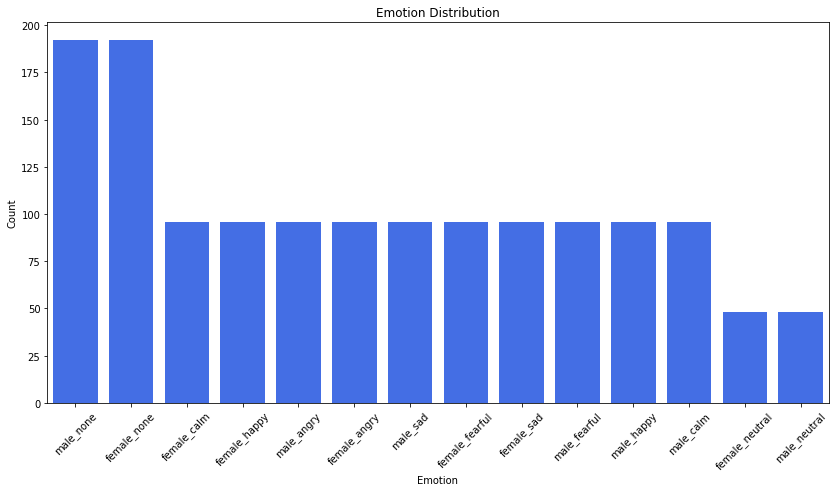

In [22]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [23]:
# Data set

data2_df = data_df.copy()

print (len(data2_df))
data2_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,1,male_neutral
1,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,1,1,male_neutral
2,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,0,1,male_neutral
3,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,1,1,1,male_neutral
4,E:/Speech_Emotion_Recognition/Actor_01/03-01-0...,1,1,male,0,0,0,2,male_calm


In [24]:
# Loading the data frame and calculating MFCC features

data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1440/1440 [04:57<00:00,  4.85it/s]


In [25]:
data.head()

,feature
0,"[-65.80214610945198, -65.80214610945198, -65.8..."
1,"[-62.62588661911115, -63.89904892123302, -64.4..."
2,"[-65.8201301169506, -65.8201301169506, -65.820..."
3,"[-66.05951544917556, -66.05951544917556, -66.0..."
4,"[-70.26907886230086, -70.26907886230086, -70.2..."


In [26]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [27]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-62.625887,-63.899049,-64.441830,-59.982699,-60.297195,-61.611843,-64.753070,-65.390711,-65.390711,-65.390711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,...,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079


In [28]:
newdf = pd.concat([df3,labels], axis=1)

In [29]:
# Renaming of the previous label
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1440

In [30]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-62.625887,-63.899049,-64.441830,-59.982699,-60.297195,-61.611843,-64.753070,-65.390711,-65.390711,-65.390711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
2,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
3,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
4,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,...,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,male_calm
5,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-65.434239,-65.635087,-67.558429,-67.558429,...,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,-67.558429,male_calm
6,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,...,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,-69.693990,male_calm
7,-69.053045,-69.053045,-69.053045,-69.053045,-69.053045,-69.005871,-69.053045,-69.053045,-69.053045,-68.918214,...,-69.053045,-69.053045,-69.053045,-69.053045,-69.053045,-69.053045,NaN,NaN,NaN,male_calm
8,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,...,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,-73.841804,male_calm
9,-69.243931,-69.243931,-69.243931,-69.243931,-69.243931,-69.112913,-69.243931,-69.166946,-66.261142,-68.245355,...,-57.991136,-61.884342,-67.038481,-68.177946,-67.128463,-69.243931,-69.243931,-69.243931,-69.243931,male_calm


In [31]:
# Number of values that are NULL in the label 'rnewdf'
rnewdf.isnull().sum().sum()

5708

In [32]:
# Filling all the NULL values with zeros
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-62.625887,-63.899049,-64.441830,-59.982699,-60.297195,-61.611843,-64.753070,-65.390711,-65.390711,-65.390711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,...,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,male_calm


In [33]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

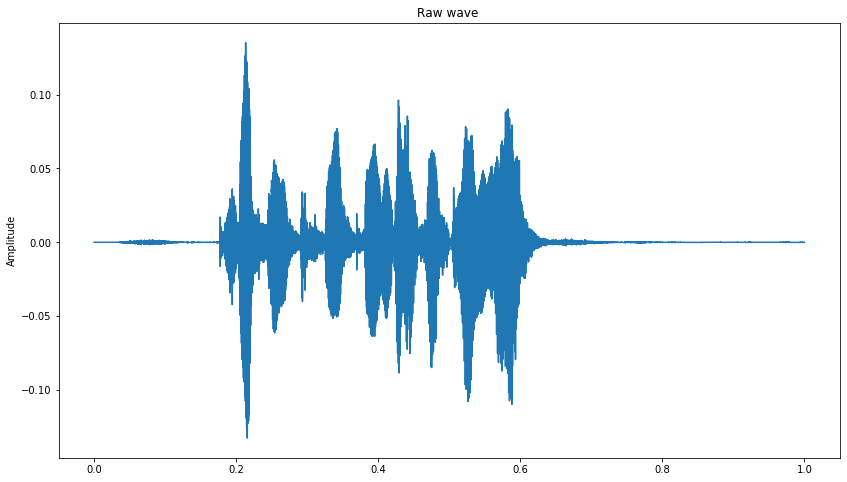

In [34]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

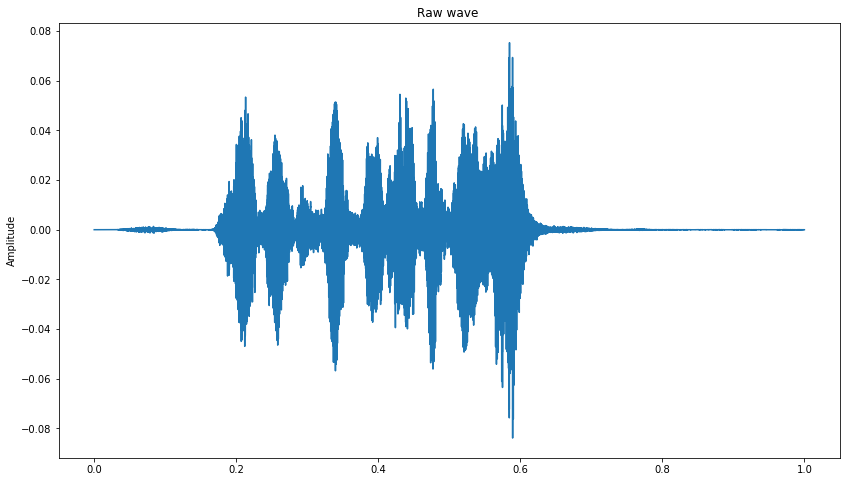

In [35]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [36]:
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 1440/1440 [05:15<00:00,  4.57it/s]


In [37]:
syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 1440/1440 [17:27<00:00,  1.37it/s]


In [38]:
len(syn_data1), len(syn_data2)

(1440, 1440)

In [39]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [40]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1440

In [41]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.846422,-54.248078,-55.108782,-53.771692,-54.331317,-52.862106,-53.332526,-55.230459,-52.702268,-54.914971,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,male_neutral
1,-50.281407,-52.914317,-53.186111,-52.214221,-53.077039,-52.962608,-52.084087,-53.202926,-52.916759,-50.994052,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,male_neutral
2,-51.236979,-49.415032,-50.991171,-51.269938,-50.723122,-50.404209,-51.338557,-51.368697,-50.142853,-51.420641,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,male_neutral
3,-54.041436,-55.473112,-55.102092,-53.447380,-54.162159,-55.035139,-57.228908,-54.754476,-53.847197,-53.873236,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,male_neutral
4,-58.444914,-57.649648,-60.469653,-61.059266,-59.548676,-57.713393,-58.104070,-59.333771,-60.231482,-60.184206,...,-58.727784,-58.519183,-57.079225,-57.642344,-58.109523,-60.027923,-60.464753,-57.738533,-60.68537,male_calm


In [42]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1440

In [43]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,-69.909963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-63.102239,-64.880447,-65.422917,-63.415645,-63.172323,-65.131065,-66.875270,-68.183036,-68.183036,-68.183036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,-67.056042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,-68.128800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,...,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,-72.682225,male_calm


In [44]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,-65.802146,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-62.625887,-63.899049,-64.441830,-59.982699,-60.297195,-61.611843,-64.753070,-65.390711,-65.390711,-65.390711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,-65.820130,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,-66.059515,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,...,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,-70.269079,male_calm


In [45]:
#  Stratified Shuffle Split
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [46]:
y_train.value_counts()

male_none         461
female_none       461
male_angry        231
female_angry      231
male_fearful      231
male_happy        231
female_calm       230
female_fearful    230
female_sad        230
male_calm         230
female_happy      230
male_sad          230
female_neutral    115
male_neutral      115
Name: label, dtype: int64

In [47]:
y_test.value_counts()

male_none         115
female_none       115
female_fearful     58
female_sad         58
female_calm        58
female_happy       58
male_calm          58
male_sad           58
male_fearful       57
male_angry         57
female_angry       57
male_happy         57
female_neutral     29
male_neutral       29
Name: label, dtype: int64

In [48]:
X_train.isna().sum().sum()

0

In [49]:
# Assigning the training and testing data to their respected variables
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [50]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [51]:
X_train.shape

(3456, 259)

In [52]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [53]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [54]:
# New model
model = Sequential()
X_train
model.add(Conv1D(256, 5, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(14))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [56]:
# Compiling the model using compile method 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [57]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('E:/SpeechRecognition/model/Emotion_Voice_Detection_Model (1).h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Train on 3456 samples, validate on 864 samples
Epoch 1/700
3456/3456 [==============================] - 51s 15ms/step - loss: 2.7513 - accuracy: 0.1328 - fscore: 0.0000e+00 - val_loss: 2.5607 - val_accuracy: 0.1887 - val_fscore: 0.0000e+00
Epoch 2/700
3456/3456 [==============================] - 50s 14ms/step - loss: 2.4301 - accuracy: 0.1985 - fscore: 5.4466e-04 - val_loss: 2.4148 - val_accuracy: 0.2431 - val_fscore: 0.0000e+00
Epoch 3/700
3456/3456 [==============================] - 37s 11ms/step - loss: 2.3339 - accuracy: 0.2338 - fscore: 0.0000e+00 - val_loss: 2.3657 - val_accuracy: 0.2581 - val_fscore: 0.0000e+00
Epoch 4/700
3456/3456 [==============================] - 32s 9ms/step - loss: 2.2799 - accuracy: 0.2509 - fscore: 0.0016 - val_loss: 2.3179 - val_accuracy: 0.2523 - val_fscore: 0.0000e+00
Epoch 5/700
3456/3456 [==============================] - 31s 9ms/step - loss: 2.2223 - accuracy: 0.2656 - fscore: 0.0060 - val_loss: 2.2747 - val_accuracy: 0.2697 - val_fscore: 0.0000e+

3456/3456 [==============================] - 32s 9ms/step - loss: 1.6648 - accuracy: 0.4135 - fscore: 0.1576 - val_loss: 1.8795 - val_accuracy: 0.3762 - val_fscore: 0.0150
Epoch 44/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.6678 - accuracy: 0.4219 - fscore: 0.1625 - val_loss: 1.9657 - val_accuracy: 0.3495 - val_fscore: 0.0109
Epoch 45/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.6456 - accuracy: 0.4262 - fscore: 0.1635 - val_loss: 1.8814 - val_accuracy: 0.3866 - val_fscore: 0.0150
Epoch 46/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.6466 - accuracy: 0.4204 - fscore: 0.1735 - val_loss: 1.8875 - val_accuracy: 0.3576 - val_fscore: 0.0131
Epoch 47/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.6336 - accuracy: 0.4225 - fscore: 0.1710 - val_loss: 1.8847 - val_accuracy: 0.3738 - val_fscore: 0.0194
Epoch 48/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.6377 - 

3456/3456 [==============================] - 32s 9ms/step - loss: 1.3791 - accuracy: 0.5145 - fscore: 0.3293 - val_loss: 1.8498 - val_accuracy: 0.3947 - val_fscore: 0.0614
Epoch 88/700
3456/3456 [==============================] - 32s 9ms/step - loss: 1.3808 - accuracy: 0.5148 - fscore: 0.3403 - val_loss: 1.6520 - val_accuracy: 0.4676 - val_fscore: 0.0641
Epoch 89/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.3767 - accuracy: 0.5229 - fscore: 0.3456 - val_loss: 1.7953 - val_accuracy: 0.3866 - val_fscore: 0.0984
Epoch 90/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.3747 - accuracy: 0.5234 - fscore: 0.3325 - val_loss: 1.7420 - val_accuracy: 0.4398 - val_fscore: 0.0726
Epoch 91/700
3456/3456 [==============================] - 32s 9ms/step - loss: 1.3594 - accuracy: 0.5182 - fscore: 0.3519 - val_loss: 1.6367 - val_accuracy: 0.4363 - val_fscore: 0.0960
Epoch 92/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.3650 - 

3456/3456 [==============================] - 32s 9ms/step - loss: 1.1742 - accuracy: 0.5969 - fscore: 0.4616 - val_loss: 1.7795 - val_accuracy: 0.4028 - val_fscore: 0.1298
Epoch 132/700
3456/3456 [==============================] - 32s 9ms/step - loss: 1.1642 - accuracy: 0.6114 - fscore: 0.4719 - val_loss: 1.4811 - val_accuracy: 0.5289 - val_fscore: 0.1615
Epoch 133/700
3456/3456 [==============================] - 32s 9ms/step - loss: 1.1328 - accuracy: 0.6296 - fscore: 0.4883 - val_loss: 1.7039 - val_accuracy: 0.4352 - val_fscore: 0.1672
Epoch 134/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.1492 - accuracy: 0.6097 - fscore: 0.4872 - val_loss: 1.6007 - val_accuracy: 0.4942 - val_fscore: 0.1596
Epoch 135/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.1444 - accuracy: 0.6212 - fscore: 0.4827 - val_loss: 1.6563 - val_accuracy: 0.4595 - val_fscore: 0.1377
Epoch 136/700
3456/3456 [==============================] - 31s 9ms/step - loss: 1.15

3456/3456 [==============================] - 32s 9ms/step - loss: 0.9943 - accuracy: 0.6748 - fscore: 0.5866 - val_loss: 1.4430 - val_accuracy: 0.5602 - val_fscore: 0.2396
Epoch 176/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.9720 - accuracy: 0.6837 - fscore: 0.5846 - val_loss: 1.5080 - val_accuracy: 0.5093 - val_fscore: 0.2358
Epoch 177/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.9798 - accuracy: 0.6869 - fscore: 0.5853 - val_loss: 1.3477 - val_accuracy: 0.5810 - val_fscore: 0.2877
Epoch 178/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.9792 - accuracy: 0.6751 - fscore: 0.5827 - val_loss: 1.4013 - val_accuracy: 0.5579 - val_fscore: 0.2553
Epoch 179/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.9638 - accuracy: 0.6829 - fscore: 0.5902 - val_loss: 1.4058 - val_accuracy: 0.5637 - val_fscore: 0.2501
Epoch 180/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.97

3456/3456 [==============================] - 32s 9ms/step - loss: 0.8209 - accuracy: 0.7462 - fscore: 0.6862 - val_loss: 1.2831 - val_accuracy: 0.6088 - val_fscore: 0.3442
Epoch 220/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.8173 - accuracy: 0.7448 - fscore: 0.6781 - val_loss: 1.3859 - val_accuracy: 0.5683 - val_fscore: 0.3424
Epoch 221/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.8100 - accuracy: 0.7405 - fscore: 0.6859 - val_loss: 1.3552 - val_accuracy: 0.5775 - val_fscore: 0.3336
Epoch 222/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.8209 - accuracy: 0.7465 - fscore: 0.6869 - val_loss: 1.2569 - val_accuracy: 0.6215 - val_fscore: 0.3717
Epoch 223/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.7978 - accuracy: 0.7471 - fscore: 0.6931 - val_loss: 1.4756 - val_accuracy: 0.5440 - val_fscore: 0.2896
Epoch 224/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.79

3456/3456 [==============================] - 33s 9ms/step - loss: 0.6875 - accuracy: 0.7928 - fscore: 0.7437 - val_loss: 1.0860 - val_accuracy: 0.6921 - val_fscore: 0.4736
Epoch 264/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.6878 - accuracy: 0.7839 - fscore: 0.7511 - val_loss: 1.2702 - val_accuracy: 0.6157 - val_fscore: 0.4308
Epoch 265/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.6501 - accuracy: 0.8050 - fscore: 0.7654 - val_loss: 1.1478 - val_accuracy: 0.6551 - val_fscore: 0.4495
Epoch 266/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.6529 - accuracy: 0.7983 - fscore: 0.7577 - val_loss: 1.2694 - val_accuracy: 0.6007 - val_fscore: 0.3946
Epoch 267/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.6487 - accuracy: 0.8047 - fscore: 0.7584 - val_loss: 1.3137 - val_accuracy: 0.5914 - val_fscore: 0.4114
Epoch 268/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.67

3456/3456 [==============================] - 31s 9ms/step - loss: 0.5427 - accuracy: 0.8388 - fscore: 0.8095 - val_loss: 1.0175 - val_accuracy: 0.6991 - val_fscore: 0.5535
Epoch 308/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.5374 - accuracy: 0.8432 - fscore: 0.8157 - val_loss: 1.0035 - val_accuracy: 0.7072 - val_fscore: 0.5681
Epoch 309/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.5223 - accuracy: 0.8516 - fscore: 0.8236 - val_loss: 1.0147 - val_accuracy: 0.6852 - val_fscore: 0.5708
Epoch 310/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.5449 - accuracy: 0.8423 - fscore: 0.8120 - val_loss: 1.0203 - val_accuracy: 0.7072 - val_fscore: 0.5645
Epoch 311/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.5359 - accuracy: 0.8458 - fscore: 0.8108 - val_loss: 1.0830 - val_accuracy: 0.6505 - val_fscore: 0.5527
Epoch 312/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.53

3456/3456 [==============================] - 31s 9ms/step - loss: 0.4407 - accuracy: 0.8779 - fscore: 0.8585 - val_loss: 0.9723 - val_accuracy: 0.7153 - val_fscore: 0.6100
Epoch 352/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.4250 - accuracy: 0.8791 - fscore: 0.8643 - val_loss: 0.9844 - val_accuracy: 0.7188 - val_fscore: 0.6043
Epoch 353/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.4451 - accuracy: 0.8762 - fscore: 0.8562 - val_loss: 0.8940 - val_accuracy: 0.7535 - val_fscore: 0.6400
Epoch 354/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.4320 - accuracy: 0.8874 - fscore: 0.8598 - val_loss: 0.9301 - val_accuracy: 0.7338 - val_fscore: 0.6176
Epoch 355/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.4501 - accuracy: 0.8718 - fscore: 0.8482 - val_loss: 0.9552 - val_accuracy: 0.7269 - val_fscore: 0.6156
Epoch 356/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.43

3456/3456 [==============================] - 31s 9ms/step - loss: 0.3632 - accuracy: 0.9065 - fscore: 0.8892 - val_loss: 1.0470 - val_accuracy: 0.6956 - val_fscore: 0.5977
Epoch 396/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.3634 - accuracy: 0.8999 - fscore: 0.8820 - val_loss: 1.1967 - val_accuracy: 0.6238 - val_fscore: 0.5651
Epoch 397/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.3486 - accuracy: 0.9115 - fscore: 0.8950 - val_loss: 1.0234 - val_accuracy: 0.6944 - val_fscore: 0.6075
Epoch 398/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.3494 - accuracy: 0.9077 - fscore: 0.8940 - val_loss: 0.8688 - val_accuracy: 0.7488 - val_fscore: 0.6779
Epoch 399/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.3670 - accuracy: 0.9002 - fscore: 0.8872 - val_loss: 0.8183 - val_accuracy: 0.7627 - val_fscore: 0.6939
Epoch 400/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.36

3456/3456 [==============================] - 33s 10ms/step - loss: 0.2832 - accuracy: 0.9291 - fscore: 0.9179 - val_loss: 0.8791 - val_accuracy: 0.7141 - val_fscore: 0.6824
Epoch 440/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.3027 - accuracy: 0.9219 - fscore: 0.9126 - val_loss: 0.8357 - val_accuracy: 0.7454 - val_fscore: 0.6788
Epoch 441/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.2840 - accuracy: 0.9308 - fscore: 0.9200 - val_loss: 0.8727 - val_accuracy: 0.7384 - val_fscore: 0.6884
Epoch 442/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.2740 - accuracy: 0.9366 - fscore: 0.9233 - val_loss: 0.7653 - val_accuracy: 0.7766 - val_fscore: 0.7209
Epoch 443/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.2827 - accuracy: 0.9297 - fscore: 0.9192 - val_loss: 0.8182 - val_accuracy: 0.7650 - val_fscore: 0.7089
Epoch 444/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.2

3456/3456 [==============================] - 31s 9ms/step - loss: 0.2338 - accuracy: 0.9439 - fscore: 0.9371 - val_loss: 0.7408 - val_accuracy: 0.7963 - val_fscore: 0.7455
Epoch 484/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.2420 - accuracy: 0.9404 - fscore: 0.9282 - val_loss: 0.7137 - val_accuracy: 0.7894 - val_fscore: 0.7624
Epoch 485/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.2459 - accuracy: 0.9398 - fscore: 0.9332 - val_loss: 0.7488 - val_accuracy: 0.7731 - val_fscore: 0.7328
Epoch 486/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.2309 - accuracy: 0.9462 - fscore: 0.9404 - val_loss: 0.7787 - val_accuracy: 0.7558 - val_fscore: 0.7377
Epoch 487/700
3456/3456 [==============================] - 33s 10ms/step - loss: 0.2385 - accuracy: 0.9459 - fscore: 0.9359 - val_loss: 0.7738 - val_accuracy: 0.7674 - val_fscore: 0.7397
Epoch 488/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.2

3456/3456 [==============================] - 31s 9ms/step - loss: 0.1931 - accuracy: 0.9572 - fscore: 0.9507 - val_loss: 0.6843 - val_accuracy: 0.8090 - val_fscore: 0.7713
Epoch 528/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1985 - accuracy: 0.9557 - fscore: 0.9520 - val_loss: 0.8879 - val_accuracy: 0.7384 - val_fscore: 0.6954
Epoch 529/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1964 - accuracy: 0.9580 - fscore: 0.9509 - val_loss: 0.7099 - val_accuracy: 0.7905 - val_fscore: 0.7589
Epoch 530/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.2012 - accuracy: 0.9531 - fscore: 0.9460 - val_loss: 0.6828 - val_accuracy: 0.7998 - val_fscore: 0.7714
Epoch 531/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.2029 - accuracy: 0.9520 - fscore: 0.9464 - val_loss: 0.6698 - val_accuracy: 0.7940 - val_fscore: 0.7767
Epoch 532/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.19

3456/3456 [==============================] - 32s 9ms/step - loss: 0.1737 - accuracy: 0.9641 - fscore: 0.9596 - val_loss: 0.6786 - val_accuracy: 0.7963 - val_fscore: 0.7649
Epoch 572/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1723 - accuracy: 0.9661 - fscore: 0.9589 - val_loss: 0.6850 - val_accuracy: 0.7870 - val_fscore: 0.7675
Epoch 573/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1729 - accuracy: 0.9638 - fscore: 0.9586 - val_loss: 0.6640 - val_accuracy: 0.7963 - val_fscore: 0.7742
Epoch 574/700
3456/3456 [==============================] - 33s 9ms/step - loss: 0.1704 - accuracy: 0.9664 - fscore: 0.9610 - val_loss: 0.7899 - val_accuracy: 0.7616 - val_fscore: 0.7333
Epoch 575/700
3456/3456 [==============================] - 34s 10ms/step - loss: 0.1798 - accuracy: 0.9627 - fscore: 0.9545 - val_loss: 0.6898 - val_accuracy: 0.8021 - val_fscore: 0.7698
Epoch 576/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1

3456/3456 [==============================] - 32s 9ms/step - loss: 0.1573 - accuracy: 0.9638 - fscore: 0.9626 - val_loss: 0.6673 - val_accuracy: 0.7940 - val_fscore: 0.7745
Epoch 616/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1616 - accuracy: 0.9664 - fscore: 0.9600 - val_loss: 0.6615 - val_accuracy: 0.7998 - val_fscore: 0.7721
Epoch 617/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1522 - accuracy: 0.9688 - fscore: 0.9643 - val_loss: 0.6701 - val_accuracy: 0.7986 - val_fscore: 0.7808
Epoch 618/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1557 - accuracy: 0.9693 - fscore: 0.9658 - val_loss: 0.6352 - val_accuracy: 0.8044 - val_fscore: 0.7906
Epoch 619/700
3456/3456 [==============================] - 32s 9ms/step - loss: 0.1530 - accuracy: 0.9693 - fscore: 0.9642 - val_loss: 0.6247 - val_accuracy: 0.7998 - val_fscore: 0.7830
Epoch 620/700
3456/3456 [==============================] - 33s 10ms/step - loss: 0.1

3456/3456 [==============================] - 31s 9ms/step - loss: 0.1402 - accuracy: 0.9719 - fscore: 0.9693 - val_loss: 0.6238 - val_accuracy: 0.8009 - val_fscore: 0.7911
Epoch 660/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1423 - accuracy: 0.9714 - fscore: 0.9694 - val_loss: 0.6216 - val_accuracy: 0.8125 - val_fscore: 0.7857
Epoch 661/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1398 - accuracy: 0.9714 - fscore: 0.9697 - val_loss: 0.6375 - val_accuracy: 0.8009 - val_fscore: 0.7870
Epoch 662/700
3456/3456 [==============================] - 42s 12ms/step - loss: 0.1367 - accuracy: 0.9737 - fscore: 0.9698 - val_loss: 0.6059 - val_accuracy: 0.8056 - val_fscore: 0.7978
Epoch 663/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1373 - accuracy: 0.9711 - fscore: 0.9685 - val_loss: 0.6527 - val_accuracy: 0.7986 - val_fscore: 0.7818
Epoch 664/700
3456/3456 [==============================] - 31s 9ms/step - loss: 0.1

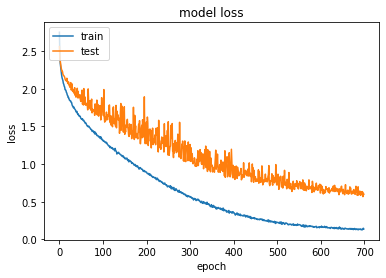

In [58]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [59]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [60]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("E:/SpeechRecognition/model/Emotion_Voice_Detection_Model (1).h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 83.33%


In [61]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 1440/1440 [01:49<00:00, 13.10it/s]


In [62]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

1440/1440 [==============================] - 3s 2ms/step


In [63]:
preds

array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [2.0375784e-02, 2.0834189e-03, 1.5761741e-03, ..., 8.6211221e-05,
        5.6344498e-04, 1.6461039e-04],
       [1.0515160e-03, 5.6541301e-03, 5.1502748e-03, ..., 5.4821983e-05,
        2.4625994e-04, 1.1469630e-02],
       [2.1847752e-03, 1.4413000e-04, 1.3447776e-04, ..., 3.7102015e-07,
        1.0312557e-04, 1.4109164e-04]], dtype=float32)

In [64]:
preds1=preds.argmax(axis=1)

In [65]:
preds1

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [66]:
abc = preds1.astype(int).flatten()

In [67]:

predictions = (lb.inverse_transform((abc)))

In [68]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_angry
1,female_angry
2,female_angry
3,female_angry
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_calm
9,male_calm


In [69]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [70]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_calm
9,male_calm


In [71]:
finaldf = actualdf.join(preddf)

In [72]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_sad,male_sad
21,male_sad,male_sad
22,male_sad,male_sad
23,male_sad,female_angry
24,male_sad,male_sad
25,male_sad,male_sad
26,male_sad,male_sad
27,male_sad,male_sad
28,male_angry,male_angry
29,male_angry,male_angry


In [73]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,96
female_calm,96
female_fearful,96
female_happy,96
female_neutral,48
female_none,192
female_sad,96
male_angry,96
male_calm,96


In [74]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,364
female_calm,92
female_fearful,82
female_happy,88
female_neutral,44
female_none,169
female_sad,87
male_angry,82
male_calm,83


In [75]:
finaldf.to_csv('E:/Predictions2.csv', index=False)